In [17]:
import numpy as np
import matplotlib.pyplot as plot
import os, sys
import re
import tensorflow as tf

from skimage import io
from skimage import color
from keras import Sequential, Input, Model, layers
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, MultiHeadAttention, LayerNormalization, Flatten, Dropout, Dense, Reshape, LSTM, Conv2DTranspose, UpSampling2D, TextVectorization
from keras.backend import clear_session
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

Downloading:  39%|███▉      | 105M/268M [09:57<15:24, 176kB/s] 


Image Generation

In [306]:
model_gen = Sequential([
    Dense(256*8*8, input_dim=100),
    Reshape((8, 8, 256)),
    Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'),
    LeakyReLU(alpha=0.3),
    UpSampling2D(),
    Conv2D(128, 3, padding='same'),
    LeakyReLU(alpha=0.3),
    Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'),
    LeakyReLU(alpha=0.3),
    Conv2D(3, (3,3), activation='tanh', padding='same')
])
model_gen.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1654784   
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      524416    
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 128)       1

In [307]:

model_discr = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", input_shape=(64, 64, 3)),
    LeakyReLU(0.3),
    Conv2D(filters=128, kernel_size=(3, 3), padding="same"),
    LeakyReLU(0.3),
    Conv2D(filters=128, kernel_size=(3, 3), padding="same"),
    LeakyReLU(0.3),
    Flatten(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])
model_discr.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_discr.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 flatten (Flatten)           (None, 524288)           

In [308]:
model_gan = Sequential()
model_gan.add(model_gen)
model_gan.add(model_discr)
model_gan.compile(loss='binary_crossentropy', optimizer='adam')

(504, 64, 64, 3)


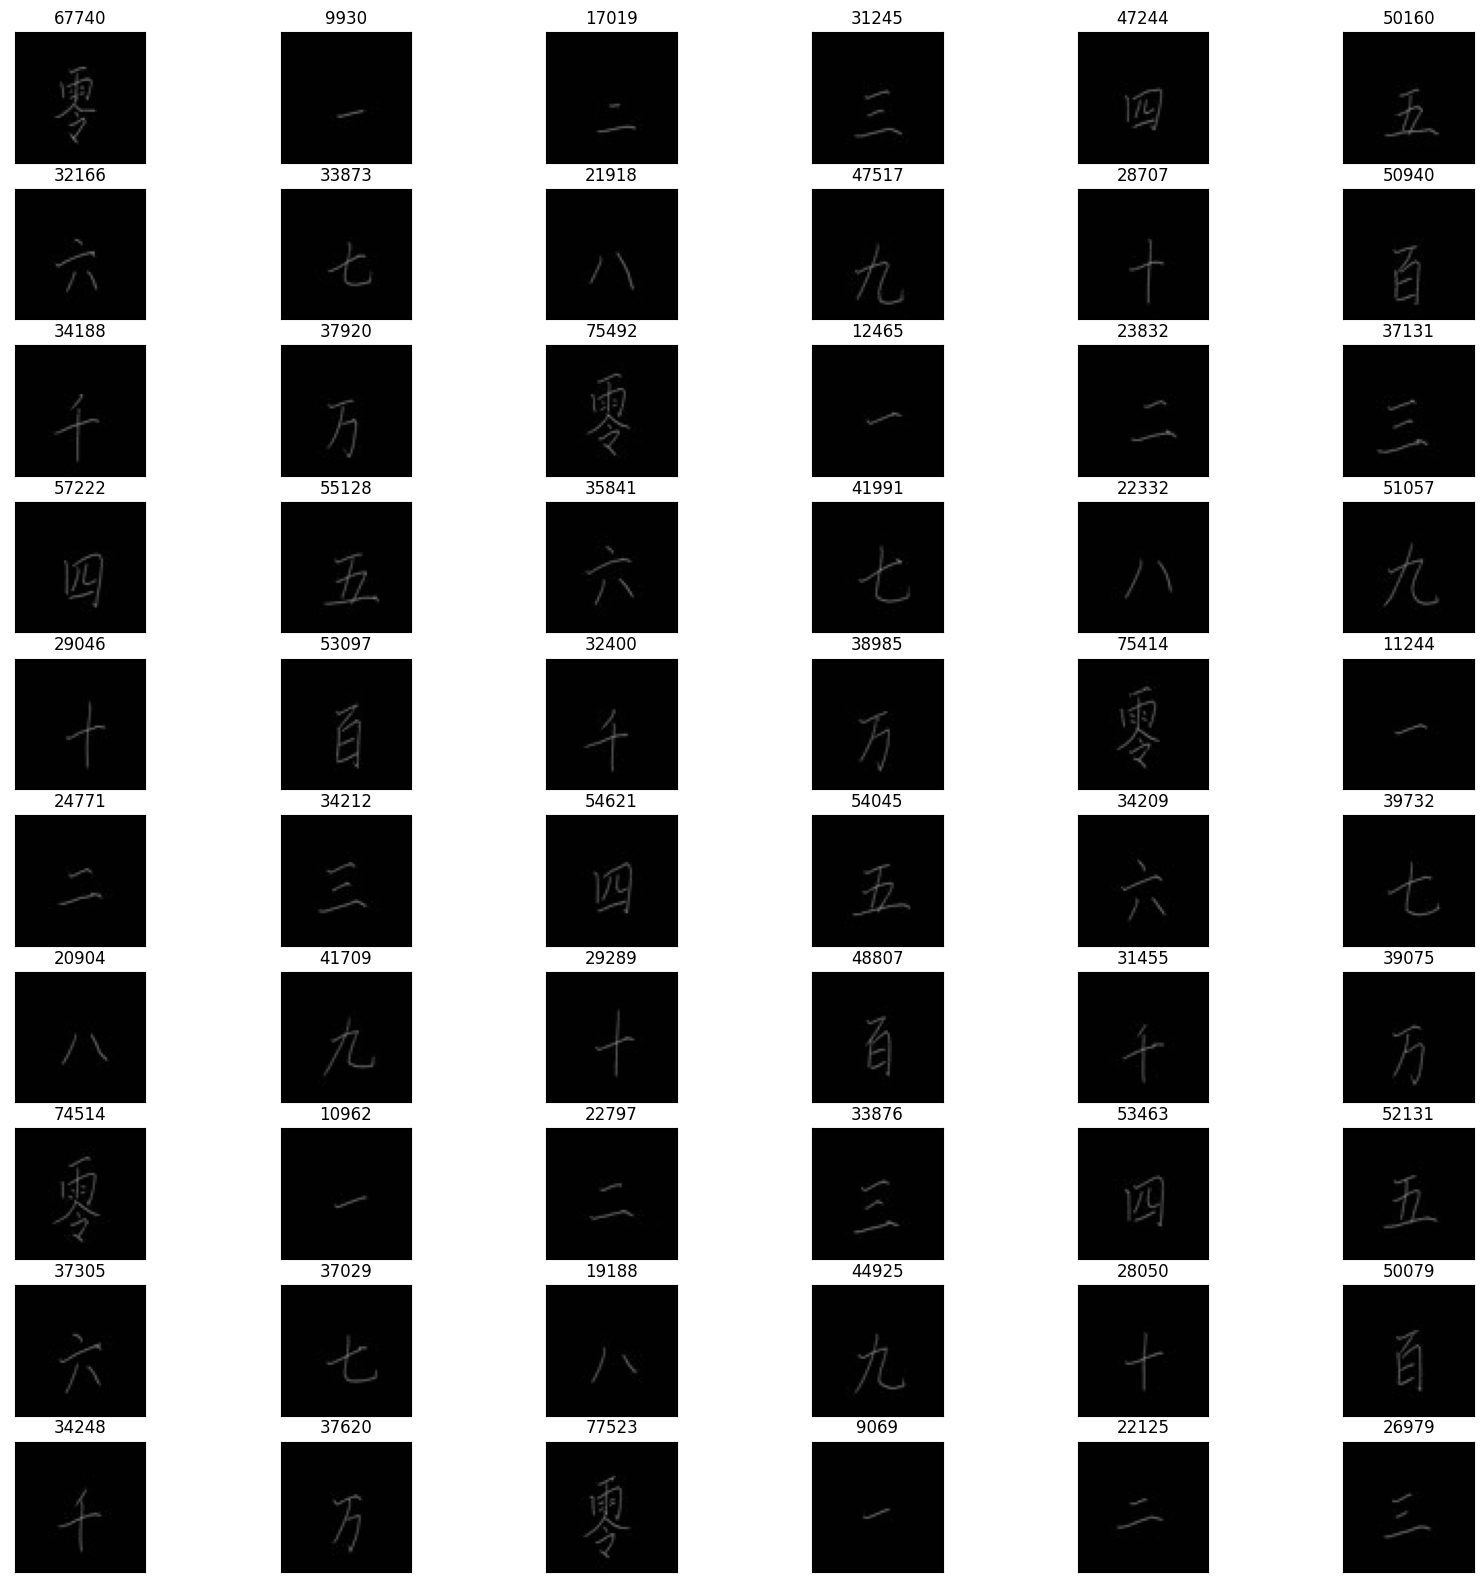

In [309]:
a_train = []
for i in range(1,5):
    for j in range(1,10):
        for k in range(1,15):
            image = io.imread("img_gen/input_" + str(i) + "_" + str(j) + "_" + str(k) + ".jpg", as_gray=False)
            image = color.gray2rgb(image)
            a_train.append(image)
a_train = np.asarray(a_train)
fig = plot.figure(figsize=(20,20))
for row in range(10):
    for column in range(6):
        i = row * 6 + column
        if i>len(a_train)-1:
            break                   
        ax = fig.add_subplot(10, 6, i+1)
        ax.set_title(str(np.sum(a_train[i])))     
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plot.imshow((a_train[i]/2 + 1).astype(np.uint64))
a_train = np.clip(a_train, -1, 1)
print(a_train.shape)

1/1 [==============================] - 0s 117ms/step
epoch: 0
1/1 [==============================] - 0s 122ms/step


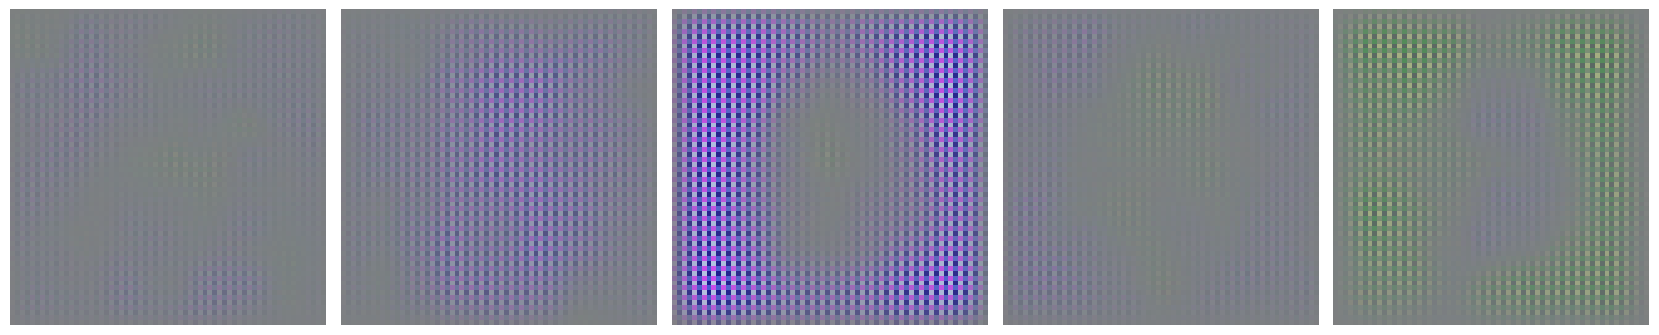

1/1 [==============================] - 0s 120ms/step
epoch: 10
1/1 [==============================] - 0s 125ms/step


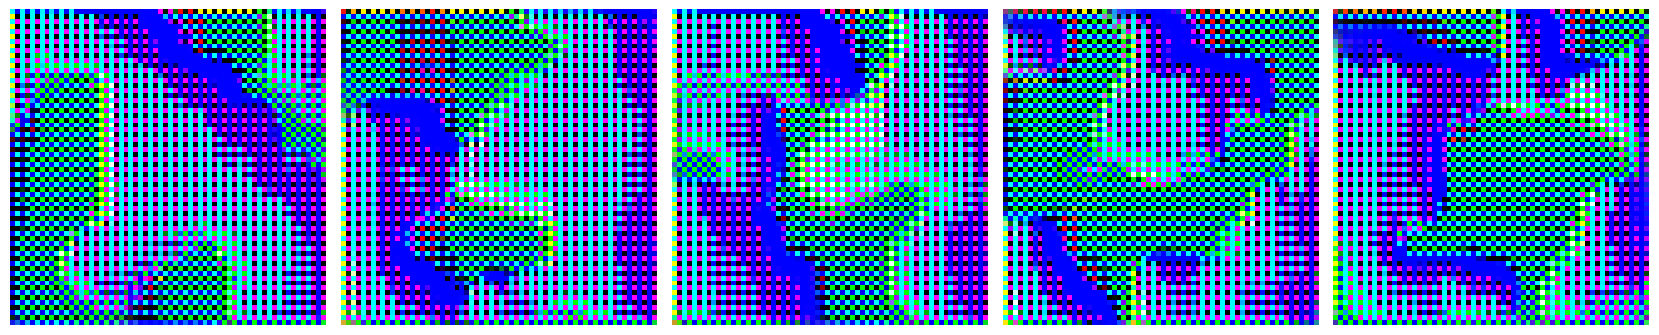

1/1 [==============================] - 0s 122ms/step
epoch: 20
1/1 [==============================] - 0s 133ms/step


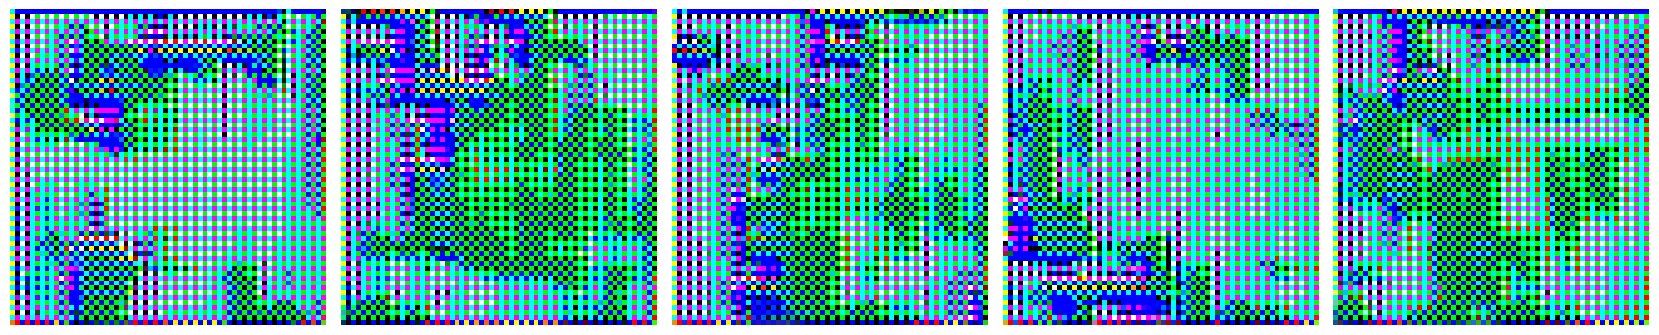

1/1 [==============================] - 0s 133ms/step


KeyboardInterrupt: 

In [310]:
discrim_losses = []
all_images = []
size = 32
num_batches = int(a_train.shape[0] / size)
for ep in range(0, 100):
    for i in range(num_batches):
        noise = np.random.normal(0, 1.0, size=[size, 100])
        image_batch = a_train[np.random.randint(0, a_train.shape[0], size=size)]
        generated_images = model_gen.predict(noise)
        X = np.concatenate([image_batch, generated_images])
        y_dis = np.zeros(2*size)
        y_dis[:size] = 0.60
        y_dis += np.random.uniform(0, 0.1, size = len(y_dis))
        model_discr.trainable = True
        d_loss, _ = model_discr.train_on_batch(X, y_dis)
        discrim_losses.append(d_loss)
        noise = np.random.normal(0, 1.0, size=[size, 100])
        y_gen = np.ones(size) 
        model_discr.trainable = False
        model_gan.train_on_batch(noise, y_gen)
    if ep % 10 == 0:
        print("epoch: " + str(ep))
        num_of_images = 6
        noise = np.random.normal(0, 1.0, size=[size, 100])
        generated_images = model_gen.predict(noise)
        generated_images = np.asarray((generated_images+1)/2.0)
        all_images.append(generated_images)
        plot.figure(figsize=(20, 4))
        for i in range(1, 6):
            plot.subplot(1, 6, i+1)
            plot.imshow(generated_images[i])
            plot.axis('off')
            plot.tight_layout()
        plot.show()
        clear_session()

TRANSLATE UKR

In [41]:
def text_to_data(text):
    lines = text.split("\n")[:-1]
    eng = []
    ukr = []
    for line in lines:
        e, u, att = line.split("\t")
        eng.append(e)
        ukr.append(u)
    eng = [re.sub(r'[^\w\s]', '', str(text).lower()) for text in eng]
    ukr = [re.sub(r'[^\w\s]', '', str(text).lower()) for text in ukr]
    return eng, ukr

text_file = open("ukr.txt", 'r', encoding='utf-8')
text = text_file.read()
eng, ukr = text_to_data(text)

vocab_size = 6000
sequence_length = 20
batch_size = 8


eng_vector = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
ukr_vector = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
)
eng_vector.adapt(eng)
ukr_vector.adapt(ukr)


In [42]:
def format_dataset(eng, spa):
    eng = eng_vector(eng)
    spa = ukr_vector(spa)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": spa[:, :-1],
        },
        spa[:, 1:],
    )


def make_dataset(eng, ukr):
    dataset = tf.data.Dataset.from_tensor_slices((eng, ukr))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(1024).prefetch(16).cache()

X_train, X_test, Y_train, Y_test = train_test_split(eng, ukr, train_size=0.6, random_state = 5)

train_ds = make_dataset(X_train, Y_train)
val_ds = make_dataset(X_test, Y_test)

In [43]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = Sequential(
            [Dense(latent_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.layernorm_3 = LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [44]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = Model(encoder_inputs, encoder_outputs)

decoder_inputs = Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = Dropout(0.5)(x)
decoder_outputs = Dense(vocab_size, activation="softmax")(x)
decoder = Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer1"
)

In [45]:
epochs = 3

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

Model: "transformer1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding_14 (Posit  (None, None, 256)   1541120     ['encoder_inputs[0][0]']         
 ionalEmbedding)                                                                                  
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder_7 (Transfo  (None, None, 256)   3155456     ['positional_embedding

In [46]:
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

11250/11250 [==============================] - 925s 82ms/step - loss: 4.9199 - accuracy: 0.3583 - val_loss: 4.4142 - val_accuracy: 0.4133


In [7]:
import torch
from transformers import pipeline, TextClassificationPipeline, AutoTokenizer, AutoModelForSequenceClassification

classifier = pipeline('text-classification')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [8]:
txt_1 = 'I am driver of the UFO'
classifier(txt_1)

[{'label': 'POSITIVE', 'score': 0.9280532002449036}]

In [9]:
txt_2 = 'New blood join this earth, and quickly he`s subdued'
classifier(txt_2)

[{'label': 'NEGATIVE', 'score': 0.9861969351768494}]

In [18]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, from_pt=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, from_pt=True)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [19]:
inputs = tokenizer([txt_1, txt_2])

In [20]:
inputs_with_padding = tokenizer(
    [txt_1, txt_2],
    padding = True,
    truncation = True,
    max_length = 256,
    return_tensors="tf"
)

outputs = model(inputs_with_padding)

In [22]:
predictions = tf.nn.softmax(outputs[0], axis=-1)
predictions

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.07194705, 0.928053  ],
       [0.98619694, 0.01380307]], dtype=float32)>